In [2]:
# Full Melody Pitch Correction (Causal TCN, Streaming)

# 1) Imports & Config
import os, json, glob, random
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

ROOT = Path("/Users/mayagambhir/3600_final")
PROC_DIR = ROOT / "data/processed/features"
META_DIR = ROOT / "metadata"
OUT_DIR = ROOT / "artifacts/full"
OUT_DIR.mkdir(parents=True, exist_ok=True)

with open(META_DIR / "feature_norm.json", "r") as f:
    norm = json.load(f)
FEATURE_MEAN = np.array(norm["feature_mean"] or [0.0]*64, dtype=np.float32)
FEATURE_STD = np.array(norm["feature_std"] or [1.0]*64, dtype=np.float32)
FPS = norm.get("frames_per_second", 100)

N_MELS = 64
SHIFT_RANGE_CENTS = 300.0

random.seed(13)
np.random.seed(13)
tf.random.set_seed(13)
print("Full melody config:", dict(n_mels=N_MELS, fps=FPS))


Full melody config: {'n_mels': 64, 'fps': 100}


In [3]:
# 2) Data loading (all categories), windowing, normalization

def list_npz(split):
    return sorted(glob.glob(str(PROC_DIR / split / '*.npz')))


def normalize_features(x):
    return (x - FEATURE_MEAN[None, :]) / (FEATURE_STD[None, :] + 1e-8)

# Create overlapping windows for training with curriculum-ready augment hooks

def make_sequences(npz_paths, T=120, stride=60, limit=None):
    xs, ys = [], []
    count = 0
    for p in npz_paths:
        arr = np.load(p)
        logmel = normalize_features(arr['logmel'].astype(np.float32))
        target_shift = arr['target_shift'].astype(np.float32)
        L = len(target_shift)
        i = 0
        while i + T <= L:
            xs.append(logmel[i:i+T])
            ys.append(target_shift[i:i+T, None])
            i += stride
            count += 1
            if limit and count >= limit:
                break
        if limit and count >= limit:
            break
    return np.array(xs), np.array(ys)

train_files = list_npz('train')
val_files = list_npz('val')
X_train, y_train = make_sequences(train_files, T=120, stride=60)
X_val, y_val = make_sequences(val_files, T=120, stride=60)
print('Shapes:', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

BATCH=32
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(4096).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(tf.data.AUTOTUNE)


Shapes: (2113, 120, 64) (2113, 120, 1) (264, 120, 64) (264, 120, 1)


In [4]:
# 3) Causal TCN with dilations (causal Conv1D blocks)
from tensorflow.keras import layers as L, models

INPUT_DIM = N_MELS

inp = L.Input(shape=(None, INPUT_DIM), name='features')
x = L.Conv1D(64, 1, padding='causal', activation='relu')(inp)

# Residual dilated blocks (replace depthwise conv with causal Conv1D to avoid padding='causal' limitation)
for d in [1, 2, 4]:
    res = x
    x = L.Conv1D(64, 3, dilation_rate=d, padding='causal', activation=None)(x)
    x = L.Conv1D(64, 1, activation='relu')(x)
    x = L.Add()([x, res])

x = L.Conv1D(64, 1, activation='relu')(x)
shift = L.Conv1D(1, 1, activation=None, name='shift_cents')(x)
conf = L.Conv1D(1, 1, activation='sigmoid', name='confidence')(x)

model = models.Model(inputs=inp, outputs=[shift, conf])
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={'shift_cents':'mae','confidence':'binary_crossentropy'},
    loss_weights={'shift_cents':1.0,'confidence':0.01},
    metrics={'shift_cents':'mae'}
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, None, 64)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 64)  │      4,160 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 64)  │      4,160 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 64)  │     12,352 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 64)  │      4,160 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 64)  │          0 │ conv1d_4[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, None, 64)  │     12,352 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, None, 64)  │      4,160 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ conv1d_6[0][0],   │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, None, 64)  │      4,160 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shift_cents         │ (None, None, 1)   │         65 │ conv1d_7[0][0]    │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ confidence (Conv1D) │ (None, None, 1)   │         65 │ conv1d_7[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,986 (226.51 KB)

 Trainable params: 57,986 (226.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - confidence_loss: 0.0397 - loss: 13.4316 - shift_cents_loss: 13.3078 - shift_cents_mae: 13.4312 - val_confidence_loss: 0.0343 - val_loss: 12.9331 - val_shift_cents_loss: 13.7623 - val_shift_cents_mae: 12.9328 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - confidence_loss: 0.0333 - loss: 13.0692 - shift_cents_loss: 13.0473 - shift_cents_mae: 13.0689 - val_confidence_loss: 0.0337 - val_loss: 13.1822 - val_shift_cents_loss: 13.9841 - val_shift_cents_mae: 13.1819 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - confidence_loss: 0.0283 - loss: 12.7936 - shift_cents_loss: 12.7209 - shift_cents_mae: 12.7933 - val_confidence_loss: 0.0277 - val_loss: 12.9117 - val_shift_cents_loss: 13.7619 - val_shift_cents_mae: 12.9114 - learning_rate: 0.0010
Epoch 4/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - confidence_loss: 0.0165 - loss: 12.1732 - shift_cents_loss: 11.9991 - shift_cents_mae: 12.17

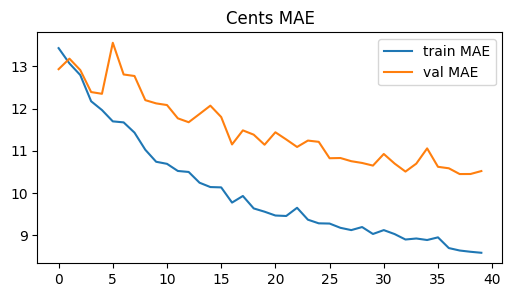

In [7]:
# 4) Training with curriculum hook (chromatic -> scale-aware)

def pack_labels(y):
    conf = tf.ones_like(y, dtype=tf.float32)
    return (y, conf)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_shift_cents_mae', mode='min', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_shift_cents_mae', mode='min', patience=7, restore_best_weights=True)
]

history = model.fit(
    train_ds.map(lambda x,y: (x, pack_labels(y))),
    validation_data=(X_val, pack_labels(y_val)),
    epochs=40,
    verbose=1,
    callbacks=callbacks
)

plt.figure(figsize=(6,3))
plt.plot(history.history['shift_cents_mae'], label='train MAE')
plt.plot(history.history['val_shift_cents_mae'], label='val MAE')
plt.legend(); plt.title('Cents MAE'); plt.show()


In [8]:
# 5) Streaming emulator (per-hop inference)

class StreamingEmulator:
    def __init__(self, model, feature_mean, feature_std):
        self.model = model
        self.fm = feature_mean.astype(np.float32)
        self.fs = feature_std.astype(np.float32)

    def step(self, frame):
        # frame: [64]
        x = (frame[None, None, :].astype(np.float32) - self.fm[None,None,:]) / (self.fs[None,None,:] + 1e-8)
        shift, conf = self.model.predict(x, verbose=0)
        return float(shift[0,0,0]), float(conf[0,0,0])

# Example: run over first validation clip frame-by-frame
if len(val_files) > 0:
    arr = np.load(val_files[0])
    frames = arr['logmel']
    sim = StreamingEmulator(model, FEATURE_MEAN, FEATURE_STD)
    out_shift = []
    out_conf = []
    for t in range(frames.shape[0]):
        s,c = sim.step(frames[t])
        out_shift.append(s); out_conf.append(c)
    print('Streaming run frames:', len(out_shift))


Streaming run frames: 501


In [10]:
# 6) Export to SavedModel and TFLite (int8)

export_dir = OUT_DIR / 'saved_model'
export_dir.mkdir(parents=True, exist_ok=True)

sig_inputs = tf.keras.Input(shape=(None, N_MELS), name='features', dtype=tf.float32)
sig_shift, sig_conf = model(sig_inputs)
serve = tf.keras.Model(inputs=sig_inputs, outputs={'shift_cents': sig_shift, 'confidence': sig_conf})

# Keras 3: export SavedModel for TFLite conversion
serve.export(str(export_dir))
print('SavedModel exported to', export_dir)

# Representative dataset windows

def rep_ds():
    for _ in range(256):
        i = np.random.randint(0, len(X_train))
        x = X_train[i:i+1].astype(np.float32)
        yield [x]

converter = tf.lite.TFLiteConverter.from_saved_model(str(export_dir))
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_ds
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()
(OUT_DIR / 'tflite').mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / 'tflite' / 'full_melody.tflite', 'wb') as f:
    f.write(tflite_model)
print('TFLite model written.')


INFO:tensorflow:Assets written to: /Users/mayagambhir/3600_final/artifacts/full/saved_model/assets


INFO:tensorflow:Assets written to: /Users/mayagambhir/3600_final/artifacts/full/saved_model/assets


Saved artifact at '/Users/mayagambhir/3600_final/artifacts/full/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 64), dtype=tf.float32, name='features')
Output Type:
  Dict[['shift_cents', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)], ['confidence', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)]]
Captures:
  13086018256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086018640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086019600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086020176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086019792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086019408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086019216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086019984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086019024: TensorSpec(shape=(), dtype=tf.r

W0000 00:00:1765211821.555604 44864409 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765211821.555621 44864409 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-08 11:37:01.555942: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /Users/mayagambhir/3600_final/artifacts/full/saved_model
2025-12-08 11:37:01.557452: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-08 11:37:01.557466: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /Users/mayagambhir/3600_final/artifacts/full/saved_model
I0000 00:00:1765211821.565824 44864409 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-12-08 11:37:01.567229: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-08 11:37:01.612496: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /Users/mayagambh

TFLite model written.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
2025-12-08 11:37:03.665611: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3705] Skipping runtime version metadata in the model. This will be generated by the exporter.
